# Data Preparation

In [1]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("XYZloan_default_selected_vars.csv")

In [4]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     data, test_size=0.40, random_state=42)

In [5]:
var = pd.DataFrame(train.dtypes).reset_index()
var.columns = ['varname','dtype'] 
var['source'] = var['varname'].str[:2]
var.head()

,varname,dtype,source
0,Unnamed: 0.1,int64,Un
1,Unnamed: 0,int64,Un
2,id,int64,id
3,loan_default,int64,lo
4,AP001,int64,AP


In [6]:
# "AP004" is a bad data field and should be removed.
MB_list = list(var[var['source']=='MB']['varname'])
AP_list = list(var[(var['source']=='AP') & (var['varname']!='AP004')]['varname'])
TD_list = list(var[var['source']=='TD']['varname'])
CR_list = list(var[var['source']=='CR']['varname'])
PA_list = list(var[var['source']=='PA']['varname'])
CD_list = list(var[var['source']=='CD']['varname'])
AP_list

['AP001', 'AP002', 'AP003', 'AP005', 'AP006', 'AP007', 'AP008', 'AP009']

In [7]:
train['loan_default'].value_counts(dropna=False)

0    38736
1     9264
Name: loan_default, dtype: int64

In [8]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_391"; Java(TM) SE Runtime Environment (build 1.8.0_391-b13); Java HotSpot(TM) 64-Bit Server VM (build 25.391-b13, mixed mode)
  Starting server from /Users/vickyma/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/h5/5b7_hbjj0090vtlzc7lw_b3r0000gn/T/tmptde41cr9
  JVM stdout: /var/folders/h5/5b7_hbjj0090vtlzc7lw_b3r0000gn/T/tmptde41cr9/h2o_vickyma_started_from_python.out
  JVM stderr: /var/folders/h5/5b7_hbjj0090vtlzc7lw_b3r0000gn/T/tmptde41cr9/h2o_vickyma_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,06 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,"28 days, 7 hours and 32 minutes"
H2O_cluster_name:,H2O_from_python_vickyma_4py7pg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


# H2O Generalized Linear Model with Regularization --GLM

The H2O Generalized Linear Model (GLM) with regularization is a statistical modeling technique used for predictive analytics. It extends the traditional GLM by incorporating regularization techniques like L1 (Lasso) and L2 (Ridge) regularization to prevent overfitting and improve model generalization. In anomaly detection, this model is useful because regularization helps to identify and prioritize important features, leading to a more robust model that can effectively discern anomalies from normal patterns in data, thereby enhancing the accuracy and reliability of anomaly detection algorithms.

## Build Model with 10% Data

In [9]:
target='loan_default'

In [10]:
train_smpl = train.sample(frac=0.1, random_state=1)
test_smpl = test.sample(frac=0.1, random_state=1)
train_hex = h2o.H2OFrame(train_smpl)
test_hex = h2o.H2OFrame(test_smpl)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
predictors = CR_list + TD_list + AP_list + MB_list + CR_list + PA_list 

In [12]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

GLM_WITH = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_search = True)
GLM_WITH.train(predictors, target, training_frame= train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1701901404050_1


GLM Model: summary
    family    link    regularization                                lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  --------------------------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 1.22E-5 )  nlambda = 100, lambda.max = 0.1112, lambda.min = 1.22E-5, lambda.1se = -1.0  76                            75                             107                     Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.1434571892703734
RMSE: 0.3787574280068622
LogLoss: 0.45342746169700415
AUC: 0.6745414386136959
AUCPR: 0.32292187966991737
Gini: 0.34908287722739173
Null degrees of freedom: 4799
Residual degrees of freedom: 4724
Null deviance: 4638.604507002493
Residual deviance: 4352.90363229124
AIC: 4504.90363229124

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.18255133829235604
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      2412  1486  0.3812   (1486.0/3898.0)
1      310   592   0.3437   (310.0/902.0)
Total  2722  2078  0.3742   (1796.0/4800.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.182551     0.397315  232
max f2                       0.125258     0.563757  304
max f0point5                 0.266912     0.344091  147
max accuracy                 0.533333     0.814792  22
max precision                0.878272     1         0
max recall                   0.0485368    1         382
max specificity              0.878272     1         0
max absolute_mcc             0.182551     0.216893  232
max min_per_class_accuracy   0.1855       0.633145  228
max mean_per_class_accuracy  0.175838     0.637847  241
max tns                      0.878272     3898      0
max fns                      0.878272     901       0
max fps                      0.00377618   3898      399
max tps                      0.0485368    902       382
max tnr                      0.878272     1         0
max fnr                      0.878272     0.998891  0
max fpr                      0.00377618   1         399
max tpr                      0.0485368    1         382

Gains/Lift Table: Avg response rate: 18.79 %, avg score: 18.79 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.501439           3.10421   3.10421            0.583333         0.582423   0.583333                    0.582423            0.0310421       0.0310421                  210.421   210.421            0.0259113
2        0.02                        0.446347           2.32816   2.71619            0.4375           0.472052   0.510417                    0.527238            0.0232816       0.0543237                  132.816   171.619            0.0422663
3        0.03                        0.416074           2.21729   2.54989            0.416667         0.427753   0.479167                    0.49407

In [15]:
y_pred = GLM_WITH.predict(test_hex).as_data_frame()
y_actual = test_hex[target].as_data_frame()
y_pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1
0,1,0.757716,0.242284
1,0,0.864940,0.135060
2,1,0.794428,0.205572
3,0,0.817654,0.182346
4,0,0.864791,0.135209


In [16]:
GLM_WITH_actual_predict = pd.concat([y_actual,y_pred['predict']],axis=1)
GLM_WITH_actual_predict.columns = ['actual','pred']
GLM_WITH_actual_predict.head()

,actual,pred
0,0,1
1,0,0
2,0,1
3,0,0
4,0,0


In [18]:
from sklearn.metrics import roc_auc_score
GLM_WITH_roc_auc_value = roc_auc_score(GLM_WITH_actual_predict['actual'],GLM_WITH_actual_predict['pred'])
GLM_WITH_roc_auc_value

0.5981410256410257

In [19]:
def createGains(model):
    predictions = model.predict(test_hex)
    test_scores = test_hex['loan_default'].cbind(predictions).as_data_frame()

    #sort on prediction (descending), add id, and decile for groups containing 1/10 of datapoints
    test_scores = test_scores.sort_values(by='predict',ascending=False)
    test_scores['row_id'] = range(0,0+len(test_scores))
    test_scores['decile'] = ( test_scores['row_id'] / (len(test_scores)/10) ).astype(int)
    #see count by decile
    test_scores.loc[test_scores['decile'] == 10]=9
    test_scores['decile'].value_counts()

    #create gains table
    gains = test_scores.groupby('decile')['loan_default'].agg(['count','sum'])
    gains.columns = ['count','actual']
    gains

    #add features to gains table
    gains['non_actual'] = gains['count'] - gains['actual']
    gains['cum_count'] = gains['count'].cumsum()
    gains['cum_actual'] = gains['actual'].cumsum()
    gains['cum_non_actual'] = gains['non_actual'].cumsum()
    gains['percent_cum_actual'] = (gains['cum_actual'] / np.max(gains['cum_actual'])).round(2)
    gains['percent_cum_non_actual'] = (gains['cum_non_actual'] / np.max(gains['cum_non_actual'])).round(2)
    gains['if_random'] = np.max(gains['cum_actual']) /10 
    gains['if_random'] = gains['if_random'].cumsum()
    gains['lift'] = (gains['cum_actual'] / gains['if_random']).round(2)
    gains['K_S'] = np.abs( gains['percent_cum_actual'] -  gains['percent_cum_non_actual'] ) * 100
    gains['gain']=(gains['cum_actual']/gains['cum_count']*100).round(2)
    gains = pd.DataFrame(gains)
    return(gains)

createGains(GLM_WITH)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,89,231,320,89,231,0.15,0.09,60.0,1.48,6.0,27.81
1,320,78,242,640,167,473,0.28,0.18,120.0,1.39,10.0,26.09
2,320,88,232,960,255,705,0.42,0.27,180.0,1.42,15.0,26.56
3,320,63,257,1280,318,962,0.53,0.37,240.0,1.32,16.0,24.84
4,320,78,242,1600,396,1204,0.66,0.46,300.0,1.32,20.0,24.75
5,320,34,286,1920,430,1490,0.72,0.57,360.0,1.19,15.0,22.40
6,320,33,287,2240,463,1777,0.77,0.68,420.0,1.10,9.0,20.67
7,320,46,274,2560,509,2051,0.85,0.79,480.0,1.06,6.0,19.88
8,320,42,278,2880,551,2329,0.92,0.90,540.0,1.02,2.0,19.13


# Best Model HyperParameter Using Grid-Search

In [28]:
import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

glm_params1 = {
    'alpha': [0, 0.2, 0.4, 0.6, 0.8, 1],  # Range of alpha values for L1 and L2 regularization
    'lambda': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1]  # Range of lambda values for regularization strength
}


glm_model = H2OGeneralizedLinearEstimator()

# Perform grid search
grid = H2OGridSearch(glm_model, glm_params1)
grid.train(x=predictors, y=target, training_frame=train_hex)


glm Grid Build progress: |███████████████████████████████████████████████████████| (done) 100%


,alpha,lambda,model_ids,residual_deviance
,0.0,1e-05,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_1,688.4066102
,0.2,1e-05,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_2,688.5428771
,0.4,1e-05,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_3,688.5770260
,0.6,1e-05,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_4,688.6021770
,0.8,1e-05,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_5,688.6402659
,1.0,1e-05,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_6,688.6597562
,0.0,0.0001,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_7,688.7894516
,0.2,0.0001,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_8,689.3381400
,0.4,0.0001,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_9,689.7824882
,0.6,0.0001,Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_10,690.5186726


In [42]:
# Get the best GLM model from the grid search
best_glm_model = grid.get_grid()[0]
best_glm_model

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: Grid_GLM_Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex_model_python_1701901404050_4_model_1


GLM Model: summary
    family    link      regularization             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 1.0E-5 )  76                            76                             1                       Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.1434180438016383
RMSE: 0.37870574830815323
MAE: 0.2878646658105599
RMSLE: 0.2658272032425307
Mean Residual Deviance: 0.1434180438016383
R^2: 0.0601946847522733
Null degrees of freedom: 4799
Residual degrees of freedom: 4723
Null deviance: 732.4991666666176
Residual deviance: 688.4066102478639
AIC: 4456.250573473435

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse        training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  -------------------  -------------------  ------------------  ------------------
    2023-12-06 18:08:47  0.000 sec   0             732.4991666666813          0.1526039930555586
    2023-12-06 18:08:47  0.019 sec   1                                                            0.37870574830815323  0.1434180438016383   0.2878646658105599  0.0601946847522733

Variable Importances: 
variable         relative_importance     scaled_importance       percentage
---------------  ----------------------  ----------------------  ----------------------
MB007.CHANGHONG  0.8703394532203674      1.0                     0.0887145489042794
MB007.LINGWIN    0.7563132047653198      0.8689864649555574      0.07709174224245668
MB007.MEDIATEK   0.6663360595703125      0.7656047960422612      0.06792028411984204
MB007.IPHONE4    0.5048225522041321      0.5800294934766246      0.05145705486495642
MB007.IPAD5      0.42394256591796875     0.48710025076919927     0.04321287901815089
MB007.ZTE        0.37210318446159363     0.42753799461206105     0.03792884033144924
MB007.QIKU       0.3509077727794647      0.4031849544233127      0.035768371356656635
MB007.LETV       0.3381386995315552      0.38851358315470896     0.03446680727275526
MB007.IPHONE8    0.31954848766326904     0.3671538575907351      0.03257188885462811
MB007.IPHONE7    0.30567777156829834     0.3512167240462919      0.031158033241405567
---              ---                     ---                     ---
TD002            0.0034615276381373405   0.0039772155856306925   0.0003528368865742964
PA023            0.003320524701848626    0.003815206457161352    0.00033846431982376336
MB007.XIAOMI     0.0031760502606630325   0.0036492086494657227   0.00032373789919494625
TD014            0.0029297771397978067   0.0033662465018186364   0.0002986350399094489
PA031            0.0028883463237434626   0.0033186434477446834   0.00029441195644081214
PA022            0.0026290658861398697   0.003020736192541875    0.0002679832486801829
MB007.VIVO       0.002577592618763447    0.0029615945930361125   0.0002627365283585517
CR005            0.0023804863449186087   0.002735124020990321    0.00024264529371941518
PA030            0.0005651374813169241   0.0006493299588176119   5.760501438653877e-05
TD015            0.00028875443967990577  0.00033177220521427286  2.9433021524562234e-05
[76 rows x 4 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [44]:
# call the createGains function with the best_glm_model
createGains(best_glm_model)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,110,210,320,110,210,0.18,0.08,60.0,1.83,10.0,34.38
1,320,75,245,640,185,455,0.31,0.18,120.0,1.54,13.0,28.91
2,320,82,238,960,267,693,0.44,0.27,180.0,1.48,17.0,27.81
3,320,63,257,1280,330,950,0.55,0.37,240.0,1.38,18.0,25.78
4,320,63,257,1600,393,1207,0.66,0.46,300.0,1.31,20.0,24.56
5,320,63,257,1920,456,1464,0.76,0.56,360.0,1.27,20.0,23.75
6,320,53,267,2240,509,1731,0.85,0.67,420.0,1.21,18.0,22.72
7,320,35,285,2560,544,2016,0.91,0.78,480.0,1.13,13.0,21.25
8,320,27,293,2880,571,2309,0.95,0.89,540.0,1.06,6.0,19.83


In [46]:
# Get the parameters of the best GLM model
best_glm_model_params = best_glm_model.params

# Extract specific parameter values
alpha_value = best_glm_model_params['alpha']
lambda_value = best_glm_model_params['lambda']

# Print the parameter values
print("alpha =", alpha_value)
print("lambda =", lambda_value)

alpha = {'default': None, 'actual': [0.0], 'input': [0.0]}
lambda = {'default': None, 'actual': [1e-05], 'input': [1e-05]}


# GLM With Regularization on whole dataset

In [47]:
train_hex2 = h2o.H2OFrame(train)
test_hex2 = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [48]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

# Create a new GLM model with specific hyperparameters
GLM_WITH2 = H2OGeneralizedLinearEstimator(family="binomial",
                                           lambda_search=False,  # Set lambda_search to False
                                           alpha=[0.0],          # Set alpha to [0.0]
                                           lambda_=[1e-05])       # Set lambda_ to [1e-05]

# Train the GLM_WITH2 model
GLM_WITH2.train(predictors, target, training_frame=train_hex)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1701901404050_5


GLM Model: summary
    family    link    regularization             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  -------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------------
    binomial  logit   Ridge ( lambda = 1.0E-5 )  76                            76                             4                       Key_Frame__upload_9049e02b5c6d9fc4a58ad35c375f4b56.hex

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.14345372795184297
RMSE: 0.3787528586715128
LogLoss: 0.4534097704784619
AUC: 0.674640557042727
AUCPR: 0.3229427222727818
Gini: 0.3492811140854539
Null degrees of freedom: 4799
Residual degrees of freedom: 4723
Null deviance: 4638.604507002493
Residual deviance: 4352.733796593236
AIC: 4506.733796593236

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.17864918020902004
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      2340  1558  0.3997   (1558.0/3898.0)
1      292   610   0.3237   (292.0/902.0)
Total  2632  2168  0.3854   (1850.0/4800.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.178649     0.397394  240
max f2                       0.125792     0.564085  307
max f0point5                 0.267158     0.344746  149
max accuracy                 0.532964     0.814792  21
max precision                0.858031     1         0
max recall                   0.0471418    1         384
max specificity              0.858031     1         0
max absolute_mcc             0.178649     0.217108  240
max min_per_class_accuracy   0.186374     0.633038  231
max mean_per_class_accuracy  0.178649     0.638291  240
max tns                      0.858031     3898      0
max fns                      0.858031     901       0
max fps                      0.00438775   3898      399
max tps                      0.0471418    902       384
max tnr                      0.858031     1         0
max fnr                      0.858031     0.998891  0
max fpr                      0.00438775   1         399
max tpr                      0.0471418    1         384

Gains/Lift Table: Avg response rate: 18.79 %, avg score: 18.79 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.502106           3.10421   3.10421            0.583333         0.580707   0.583333                    0.580707            0.0310421       0.0310421                  210.421   210.421            0.0259113
2        0.02                        0.446458           2.32816   2.71619            0.4375           0.472113   0.510417                    0.52641             0.0232816       0.0543237                  132.816   171.619            0.0422663
3        0.03                        0.415837           2.21729   2.54989            0.416667         0.427811   0.479167                    0.493544            0.0221729       0.0764967                  121.729   154.989            0.057256
4        0.04                        0.395279           1.44124   2.27273            0.270833         0.405827   0.427083                    0.471615            0.0144124       0.0909091         

In [49]:
y_pred2 = GLM_WITH2.predict(test_hex).as_data_frame()
y_actual2 = test_hex[target].as_data_frame()
y_pred.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,predict,p0,p1
0,1,0.757716,0.242284
1,0,0.864940,0.135060
2,1,0.794428,0.205572
3,0,0.817654,0.182346
4,0,0.864791,0.135209


In [50]:
GLM_WITH2_actual_predict = pd.concat([y_actual2,y_pred2['predict']],axis=1)
GLM_WITH2_actual_predict.columns = ['actual','pred']
GLM_WITH2_actual_predict.head()

,actual,pred
0,0,1
1,0,0
2,0,1
3,0,1
4,0,0


In [51]:
GLM_WITH2_roc_auc_value = roc_auc_score(GLM_WITH2_actual_predict['actual'],GLM_WITH2_actual_predict['pred'])
GLM_WITH2_roc_auc_value

0.6029487179487178

In [52]:
createGains(GLM_WITH2)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


,count,actual,non_actual,cum_count,cum_actual,cum_non_actual,percent_cum_actual,percent_cum_non_actual,if_random,lift,K_S,gain
decile,,,,,,,,,,,,
0,320,91,229,320,91,229,0.15,0.09,60.0,1.52,6.0,28.44
1,320,87,233,640,178,462,0.30,0.18,120.0,1.48,12.0,27.81
2,320,76,244,960,254,706,0.42,0.27,180.0,1.41,15.0,26.46
3,320,69,251,1280,323,957,0.54,0.37,240.0,1.35,17.0,25.23
4,320,76,244,1600,399,1201,0.66,0.46,300.0,1.33,20.0,24.94
5,320,39,281,1920,438,1482,0.73,0.57,360.0,1.22,16.0,22.81
6,320,29,291,2240,467,1773,0.78,0.68,420.0,1.11,10.0,20.85
7,320,43,277,2560,510,2050,0.85,0.79,480.0,1.06,6.0,19.92
8,320,45,275,2880,555,2325,0.92,0.89,540.0,1.03,3.0,19.27


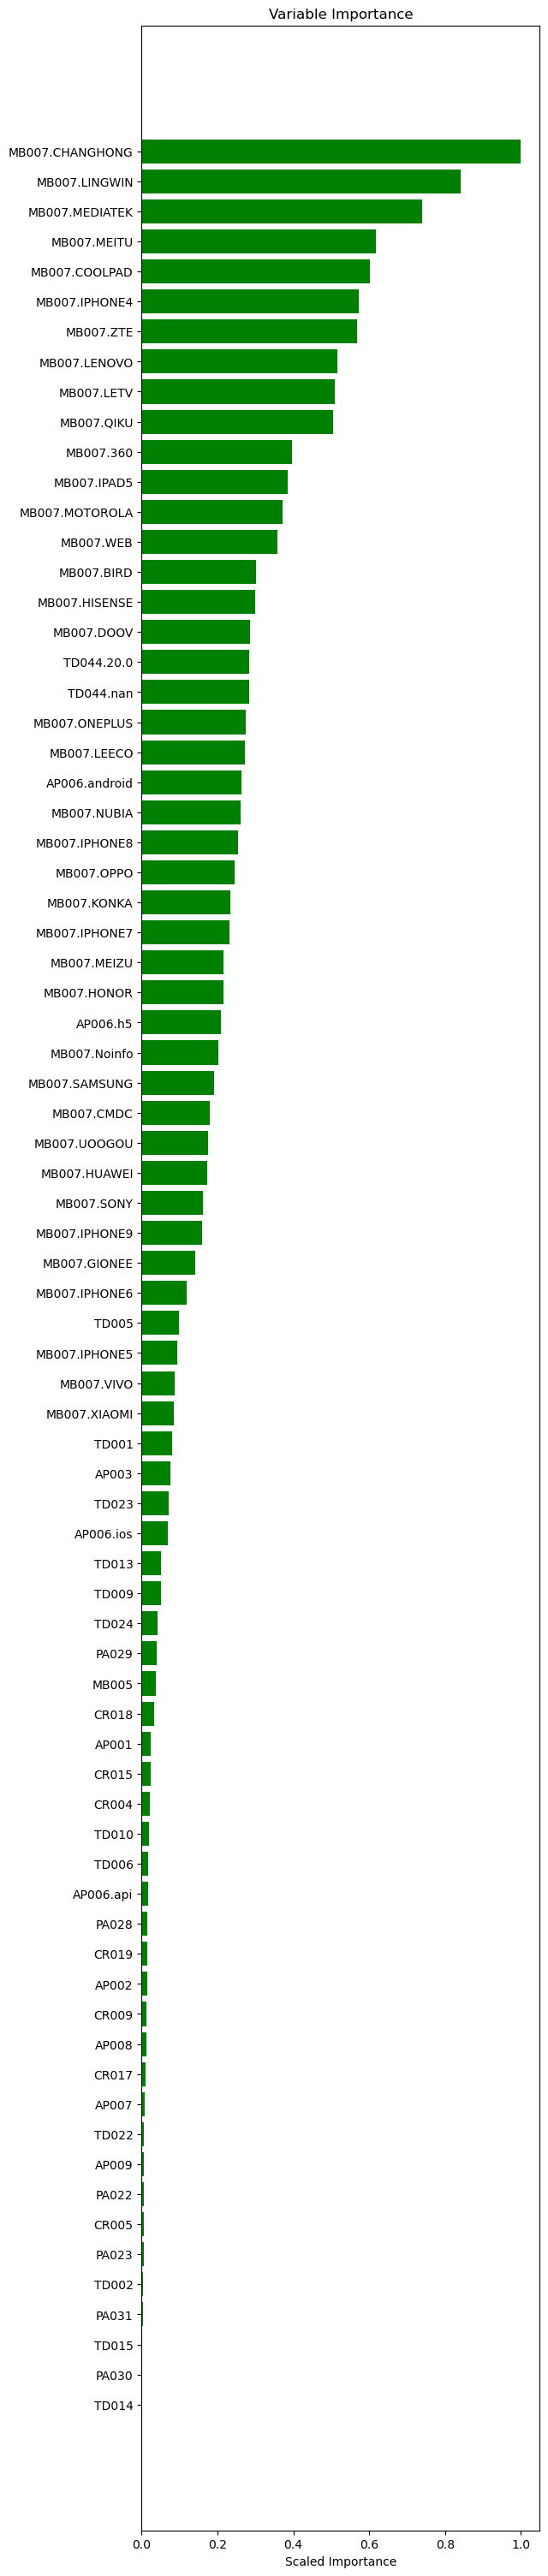

In [53]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

VarImp(GLM_WITH2)

# Interpretations for GLM-Regularization:
1. Decile Analysis:
- In the first decile, I have 320 instances, and the model predicted 91 actual positive cases. The lift is 1.52, indicating that this decile is 1.52 times more likely to contain actual positive cases than random chance.
- The K-S value of 6.0 suggests fine discrimination between positive and negative cases.
2. Variable Importance:
- "MB007" is the most important variable. This means that changes in "MB007" have the most significant impact on the model's predictions.
3. Scoring History:
- Hyperparameter tunning does not appear a significant impact on the model performance.
- AUC is 0.6029, indicating some level of discrimination between positive and negative instances.

# AutoML

H2O Automatic Machine Learning (AutoML) is a comprehensive and automated machine learning solution provided by H2O.ai. It streamlines the process of model selection, hyperparameter tuning, and feature engineering, enabling users to build high-performing predictive models with minimal manual intervention. In the context of anomaly detection, H2O AutoML is valuable because it efficiently explores a diverse set of algorithms and configurations, identifying the most effective model for detecting anomalies in complex datasets. Its automation capabilities help users with limited expertise in machine learning to deploy robust anomaly detection solutions, saving time and ensuring optimal model performance.

In [56]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [58]:
from h2o.automl import H2OAutoML
aml = H2OAutoML(max_models=20, seed=1)
aml.train(x=predictors, y=target, training_frame=train_hex)

AutoML progress: |
18:57:43.545: _train param, Dropping bad and constant columns: [CR012, AP005]
18:57:43.545: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
19:00:11.641: _train param, Dropping bad and constant columns: [CR012, TD029, TD028, TD027, TD026, TD025, AP005]
19:00:11.641: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

██
19:00:18.599: _train param, Dropping bad and constant columns: [CR012, AP005]
19:00:18.599: _response param, We have detected that your response column has only 2 unique values (0/1). If you wish to train a binary model instead of a regression model, convert your target column to categorical before training.

█
19:00

key,value
Stacking strategy,cross_validation
Number of base models (used / total),16/20
# GBM base models (used / total),4/7
# XGBoost base models (used / total),7/7
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),3/4
# DRF base models (used / total),1/1
Metalearner algorithm,GLM
Metalearner fold assignment scheme,Random
Metalearner nfolds,5


In [59]:
# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_3_20231206_185743,0.383777,0.147285,0.295467,0.269141,0.147285
StackedEnsemble_BestOfFamily_1_AutoML_3_20231206_185743,0.383876,0.147361,0.295773,0.269187,0.147361
GBM_grid_1_AutoML_3_20231206_185743_model_2,0.384447,0.1478,0.296266,0.269542,0.1478
GLM_1_AutoML_3_20231206_185743,0.384557,0.147884,0.296313,0.269923,0.147884
GBM_5_AutoML_3_20231206_185743,0.384972,0.148204,0.296252,0.269957,0.148204
DeepLearning_1_AutoML_3_20231206_185743,0.385061,0.148272,0.294501,0.270114,0.148272
GBM_2_AutoML_3_20231206_185743,0.385425,0.148552,0.296071,0.27038,0.148552
GBM_1_AutoML_3_20231206_185743,0.385435,0.14856,0.295422,0.270696,0.14856
GBM_3_AutoML_3_20231206_185743,0.385664,0.148737,0.295991,0.270661,0.148737
XGBoost_3_AutoML_3_20231206_185743,0.38708,0.149831,0.294459,0.27213,0.149831


# Interpretation For AutoML

1. The AutoML process involved the training of multiple machine learning models that were trained and evaluated, including generalized linear models (GLM), gradient boosting machines (GBM), XGBoost, deep learning models, and a stacked ensemble model. The stacked ensemble model is a combination of the individual models, leveraging their diverse strengths to achieve better predictive performance.

2. The reported metrics, such as Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R-squared (R²), provide insights into the performance of the models on both the training and cross-validation datasets. The final stacked ensemble model achieved an MSE of 0.147 on the cross-validation data, indicating the average squared difference between predicted and actual values. The R-squared value of 0.054 suggests that the model explains a limited proportion of the variance in the target variable.

3. The Leaderboard table summarizes the performance metrics for various machine learning models generated during the AutoML process. Each row corresponds to a different model, and the columns provide information about the model's performance based on different evaluation metrics: For instance, the first row corresponds to a Stacked Ensemble model with a model ID of "StackedEnsemble_AllModels_1_AutoML_3_20231206_185743." This model achieved an RMSE of 0.383777, MSE of 0.147285, MAE of 0.295467, RMSLE of 0.269141, and a mean_residual_deviance of 0.147285.

4.  Lower values for these metrics generally indicate better predictive performance. so model ID of "XGBoost_1_AutoML_3_20231206_185743" is the best model for this dataset for it achieved a RMSE of 0.420801, MSE of 0.177073, MAE of 0.313255, RMSLE of 0.304246 and a mean_residuak_deviance of 0.177073.
